# Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


## Camera Calibration

The code for this step is contained in the first code cell of this IPython notebook.  
I start by preparing "object points", which will be the (x, y, z) coordinates of the chessboard corners in the world. Here I am assuming the chessboard is fixed on the (x, y) plane at z=0, such that the object points are the same for each calibration image.  Thus, `objp` is just a replicated array of coordinates, and `objpoints` will be appended with a copy of it every time I successfully detect all chessboard corners in a test image.  `imgpoints` will be appended with the (x, y) pixel position of each of the corners in the image plane with each successful chessboard detection.  
I then used the output `objpoints` and `imgpoints` to compute the camera calibration and distortion coefficients using the `cv2.calibrateCamera()` function.  I applied this distortion correction to the test image using the `cv2.undistort()` function and obtained this result: 

(720, 1280, 3)


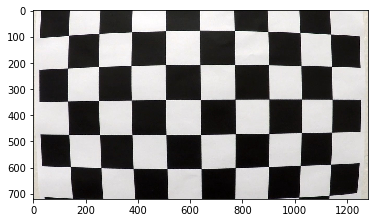

In [55]:
# Original chessboard image
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

image = mpimg.imread('./camera_cal/calibration1.jpg')
print(image.shape)
plt.imshow(image)

**Some quick observations**

- Image size is consistent
- Number of intersections slightly differ. There would be the rare occurence where there is 9 by 5 x-y interactions on the chessboard. Normally, most of the images in the calibrartion folder is 9 by 6. The algorithm below is done such that it will ignore such cases

In [56]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

def get_chessboard_corners(fname, nx, ny):
    '''
    Convenience function for testing out chessboard detection
    Returns ret (boolean if result is available), corners coordinates and images
    '''
    img = cv2.imread(fname)

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    # If found, draw corners
    if ret == True:
        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
    
    return ret, corners, img

def get_object_points(nx, ny):
    '''
    Function to get the object points needed to find the points on the chess board
    Prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    '''
    objp = np.zeros((nx*ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)
    return objp
    
def get_obj_img_points(image_fname_list, nx, ny):
    '''
    Function to obtain the object and image point 
    '''
    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.
    
    # Define a default object point
    objp = get_object_points(nx, ny) 
    
    # Step through the list and search for chessboard corners
    for fname in image_fname_list:
        # Find the chessboard corners
        ret, corners, mod_image = get_chessboard_corners(fname, nx, ny)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            
    return objpoints, imgpoints
            

In [57]:
# Function testing - all are made to comments as they are only used for testing purposes

# Testing out the functions defined in the above cell
ret, corner, img = get_chessboard_corners('./camera_cal/calibration1.jpg', 9, 5)

True

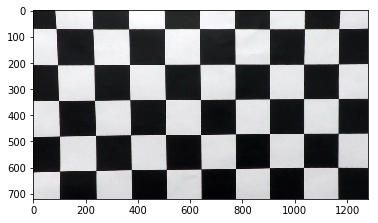

In [58]:
%matplotlib inline

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Get the object points and image points from a set of calibration images
objpoints, imgpoints = get_obj_img_points(images, 9, 6)

# Test undistortion on an image
img = cv2.imread('./camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

# Undistort
dst = cv2.undistort(img, mtx, dist, None, mtx)

# Show image
plt.imshow(dst)

# Write the file out into the output folder
cv2.imwrite('./output_images/calibration1_undist.jpg',dst)

## Pipeline (single images)

To demonstrate this step, I will describe how I apply the distortion correction to one of the test images like this one:




(720, 1280, 3)


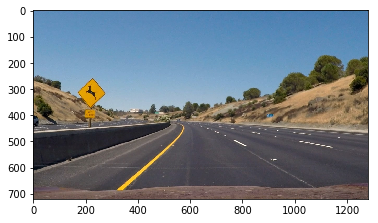

In [139]:
# Original chessboard image
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Original Image
image = mpimg.imread('./test_images/test2.jpg')
print(image.shape)
plt.imshow(image)

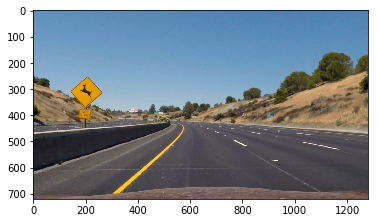

In [140]:
# Undistorted Image
dst = cv2.undistort(image, mtx, dist, None, mtx)
plt.imshow(dst)

**Describe how (and identify where in your code) you used color transforms, gradients or other methods to create a thresholded binary image.  Provide an example of a binary image result.**

I used a combination of color and gradient thresholds to generate a binary image. In order to test the combinations of binary images at a faster pace, we would create all the required thresholding functions which would include the following:

- rgb threshold functions. They deal with trying to get the image into a single color channel and see if using such a color channel would be able to provide enough information in order to get the lane lines
- hls threshold functions. They deal with trying to get the image into a single color channel but instead of the usual rgb channel, they deal with the hls channel. They will see if using such a color channel would be able to provide enough information in order to get the lane lines
- direction threshold function. They deal with changes in the direction of gradient change of the image
- magniture threshold function. They deal with changes in the magnitude of gradient change of the image
- sobel x threshold. Utiilizes sobel algorithm to get the gradients in the image by the x axis of the image
- sobel y threshold. Utiilizes sobel algorithm to get the gradients in the image by the y axis of the image

In [141]:
# Define color threshold functions - Can choose to utilize which one of the color gradients work best

def rgb_threshold(image, filter=None, mode=None, lower_threshold=None, upper_threshold=None):
    '''
    Provide RGB image for processing. Allows one to select color filter and even color thresholding
    '''
    # Apply color filter
    if filter == 'r':
        image = image[:,:,0]
    if filter == 'g':
        image = image[:,:,1]
    if filter == 'b':
        image = image[:,:,2]
    
    # Allow user to select to binarize the image based on a threshold
    if mode == 'binary':
        binary_image = np.zeros_like(image)
        binary_image[(image > lower_threshold) & (image <= upper_threshold)] = 1
        return binary_image
    else:
        return image

def hls_threshold(image, filter=None, mode=None, lower_threshold=None, upper_threshold=None):
    '''
    Provide RGB image for processing. Image will be converted to hls image. Allow one to select hls filter and hls
    thresholding
    '''
    # Convert to hls image
    image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    
    # Apply color filter
    if filter == 'h':
        image = image[:,:,0]
    if filter == 'l':
        image = image[:,:,1]
    if filter == 's':
        image = image[:,:,2]
    
    # Allow user to select to binarize the image based on a threshold
    if mode == 'binary':
        binary_image = np.zeros_like(image)
        binary_image[(image > lower_threshold) & (image <= upper_threshold)] = 1
        return binary_image
    else:
        return image

In [152]:
road_image = mpimg.imread("./test_images/test2.jpg")
road_image = cv2.undistort(road_image, mtx, dist, None, mtx)

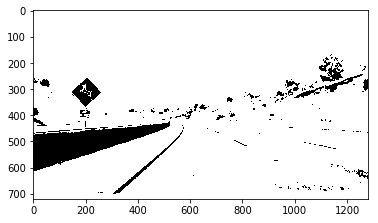

In [153]:
# Testing with just red filter doesn't work
# Test on every single color reveals that none of them work really well because of the shadow. 
# Red may work with some images but it can miserably fail at some of them
rgb_binary = rgb_threshold(road_image, 'r', 'binary', 60, 200)
plt.imshow(rgb_binary, cmap='gray')

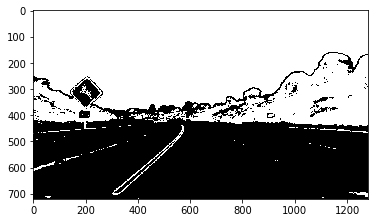

In [154]:
# Testing with just red filter doesn't work
#road_image = mpimg.imread("./test_images/test5.jpg")
hls_binary = hls_threshold(road_image, 's', 'binary', 50, 220)
plt.imshow(hls_binary, cmap='gray')

In [155]:
# Define a function called sobel
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

# Define a function to return the magnitude of the gradient
# for a given sobel kernel size and threshold values
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

# Define a function that takes an image, gradient orientation,
# and threshold min / max values.
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output

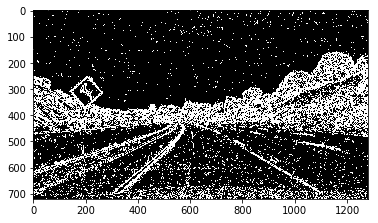

In [156]:
#road_image = mpimg.imread("./test_images/test1.jpg")
gradx = abs_sobel_thresh(road_image, 'x', 5, 200)
plt.imshow(gradx, cmap='gray')

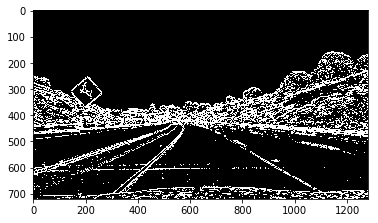

In [157]:
#road_image = mpimg.imread("./test_images/test5.jpg")
grady = abs_sobel_thresh(road_image, 'y', 10, 200)
plt.imshow(grady, cmap='gray')

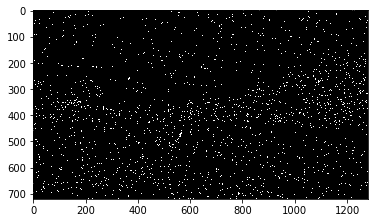

In [158]:
#road_image = mpimg.imread("./test_images/test1.jpg")
dir_binary = dir_threshold(road_image, 3, (0.6, 0.7))
plt.imshow(dir_binary, cmap='gray')

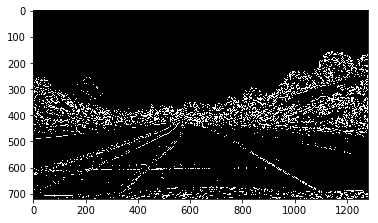

In [159]:
#road_image = mpimg.imread("./test_images/test5.jpg")
mag_binary = mag_thresh(road_image,3, mag_thresh=(15,30))
plt.imshow(mag_binary, cmap='gray')

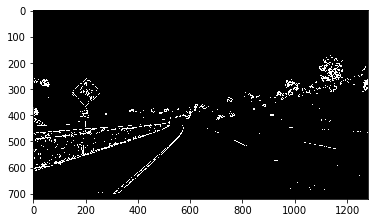

In [160]:
combined = np.zeros_like(rgb_binary)
# combined[((gradx == 1) & (grady == 1)) | 
#        ((mag_binary == 1) & (dir_binary == 0)) | 
#          ((rgb_binary == 0) & (hls_binary == 1))] = 1
# combined[((rgb_binary == 1) | (hls_binary == 1))] = 1
combined[((rgb_binary == 0) & (gradx == 1)) |
         ((rgb_binary == 0) & (grady == 1))] = 1
plt.imshow(combined, cmap='gray')

**Describe how (and identify where in your code) you performed a perspective transform and provide an example of a transformed image.**

The code for my perspective transform includes a function called `perpective_warper()`, which appears in the next codeblock.  The `perspective_warper()` function takes as inputs an image (`img`), as well as source (`src`) and destination (`dst`) points.  I chose the hardcode the source and destination points in the following manner:

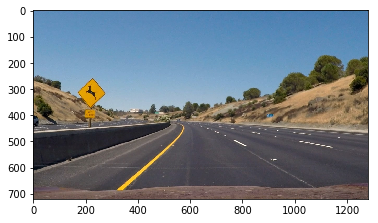

In [161]:
road_image = mpimg.imread("./test_images/test2.jpg")
plt.imshow(road_image)
# Undistort
dst = cv2.undistort(road_image, mtx, dist, None, mtx)
img_size = dst.shape

# # Zoomed-out version
# src = np.float32(
# [[580, 450],
# [40, 720],
# [1240, 720],
# [700, 450]])

# # Zoomed-in version
# src = np.float32(
# [[600, 450],
# [200, 720],
# [1000, 720],
# [680, 450]])

# Zoomed-in version
src = np.float32(
[[520, 500],
[200, 720],
[1000, 720],
[730, 500]])

# dst = np.float32(
#     [[0, 0],
#     [0, 720],
#     [1280, 720],
#     [1280, 0]])

dst = np.float32(
    [[(img_size[1] / 4), 0],
    [(img_size[1] / 4), img_size[0]],
    [(img_size[1] * 3 / 4), img_size[0]],
    [(img_size[1] * 3 / 4), 0]])

# For use in the later portion of this notebook
Minv = cv2.getPerspectiveTransform(dst, src)

def perspective_wrapper(img, src, dst):
    img_size = (img.shape[1], img.shape[0])
    
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # Warp the image using OpenCV warpPerspective()
    perspective_transform = cv2.warpPerspective(img, M, img_size)
    
    return perspective_transform

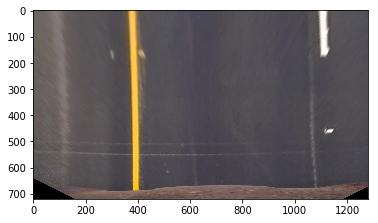

In [162]:
warped_image = perspective_wrapper(road_image, src, dst)
plt.imshow(warped_image)

**Describe how (and identify where in your code) you identified lane-line pixels and fit their positions with a polynomial?**

The lane pixels were fitted to a polynomial with the following functions below.
The comments within the functions describe the purpose of the function and how it would provide

In [163]:
# Function to get the starting point of the function
def get_start_points(binary_warped):
    '''
    Return the starting point for the left and right lanes
    '''
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    return leftx_base, rightx_base

def get_initial_indices(binary_warped, leftx_base, rightx_base, nwindows=9, margin = 100, minpix = 50):
    '''
    Get initial left and right lane indices
    Provides the left and right fit in order to get the smoothen out version of the lane lines being detected
    '''
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
            
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return out_img, left_fit, right_fit, left_lane_inds, right_lane_inds, nonzerox, nonzeroy

def plot_lane_fit(binary_warped, out_img, left_fit, right_fit, left_lane_inds, right_lane_inds, nonzerox, nonzeroy):
    '''
    Plot results form previous lane line calculations
    No actual calculations is being used for this further downstream
    '''
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Color left lane points red
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    # Color right lane points blue
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    return out_img
    
def get_indices(binary_warped, left_fit, right_fit, margin=100):
    '''
    Get the left and right indices based on previous left and right fits
    '''
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting

    return left_fit, right_fit, left_fitx, right_fitx, nonzerox, nonzeroy, left_lane_inds, right_lane_inds

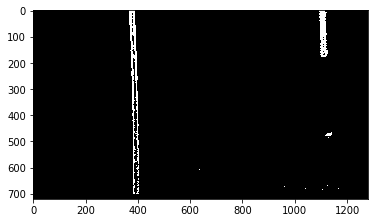

In [164]:
%matplotlib inline

# Get the warped image from above
binary_warped = perspective_wrapper(combined, src, dst)
plt.imshow(binary_warped, cmap='gray')

(720, 0)

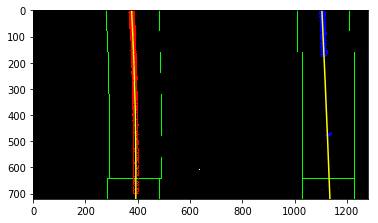

In [165]:
%matplotlib inline

# Run the above functions to get the polyfits for the following road
leftx_base, rightx_base = get_start_points(binary_warped)
out_img, left_fit, right_fit, left_lane_inds, right_lane_inds, nonzerox, nonzeroy = get_initial_indices(binary_warped, leftx_base, rightx_base)
out_img = plot_lane_fit(binary_warped, out_img, left_fit, right_fit, left_lane_inds, right_lane_inds, nonzerox, nonzeroy)

ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

(720, 0)

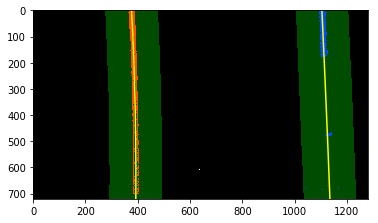

In [166]:
left_fit, right_fit, left_fitx, right_fitx, nonzerox, nonzeroy, left_lane_inds, right_lane_inds = get_indices(binary_warped, left_fit, right_fit)

# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

margin = 100

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

**Describe how (and identify where in your code) you calculated the radius of curvature of the lane and the position of the vehicle with respect to center.**

I did this in the next following block of code

In [167]:
def get_pixel_curvature(max_height, left_fit, right_fit):
    '''
    Generate the curvature based on pixel dimensions
    '''
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    return left_curverad, right_curverad
    
def get_world_curvature(nonzerox, nonzeroy, left_lane_inds, right_lane_inds, ym_per_pix, xm_per_pix):
    y_eval = 719
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    return left_curverad, right_curverad

In [168]:
# Test out functions defined above
get_pixel_curvature(719, left_fit, right_fit)

(12042.540459689748, 77504.214692199341)

In [169]:
xm_per_pix = 3.7/500
ym_per_pix = 3/100
get_world_curvature(nonzerox, nonzeroy, left_lane_inds, right_lane_inds, ym_per_pix, xm_per_pix)

(1464.5118071581055, 9407.1271592637113)

**Observations**

Although, world curvature looks parallel at first glance, when calculations are done, it shows huge differences in the world curvature. This is kind of expected, seeing that this stretch of road is quite straight. Any slight deviations would lead to huge diffences in curvature.

**Provide an example image of your result plotted back down onto the road such that the lane area is identified clearly.**

I implemented this step in next set of code blocks. You can view the image for the lane there.

In [170]:
# Function to generate the x points when given a fit object
def generate_fitx_values(fit):
    fitx = fit[0]*ploty**2 + fit[1]*ploty + fit[2]
    return fitx

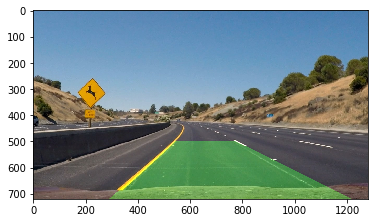

In [171]:
# Initialization to draw the image on
warped = binary_warped
warp_zero = np.zeros_like(warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Get the x-y coordinates on where to draw the lines
ploty = np.linspace(0, 719, num=720)
left_fitx = generate_fitx_values(left_fit)
right_fitx = generate_fitx_values(right_fit)

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (road_image.shape[1], road_image.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(road_image, 1, newwarp, 0.3, 0)
plt.imshow(result)

In [132]:
# Define a class to receive the characteristics of each line detection
# This class will only be limited to get information, and not to do calculation
# To store the details of the left line and right line separately
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # Store last n set of fits
        self.fits = []
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        # value of n
        self.n = 5
        self.realWorldYMul = 3/100 # Denomintator is no of pixels covered. For Y is the length of a lane
        self.realWorldXMul = 3.7/500 # Denominator is no of pixels covered. For X is the width of a standard lane
        
    def lineDetected(self, detected):
        '''
        Store boolean on whether line was detected or not
        '''
        self.detected = detected
        
    def storeFits(self, fit):
        '''
        Store last n iterations of fits
        '''
        self.fits.append(fit)
        if len(self.fits) >=  self.n:
            self.fits.pop(0)
        
    def storeXFitted(self, fit):
        '''
        Add new value to the list at the back. If there were more than n fits of the line, remove first instance
        This is not getting the fit but rather the x values produced by the fit
        '''
        no_of_fits = len(self.fits)
        ploty = np.linspace(0, len(self.fits[(no_of_fits - 1)]) - 1, num=len(self.fits[(no_of_fits - 1)]))
        xfitx = fit[0]*ploty**2 + fit[1]*ploty + fit[2]
        self.recent_xfitted.append(xfitx)
        if len(self.recent_xfitted) >= self.n:
            self.recent_xfitted.pop(0)
        
    def getBestX(self):
        '''
        Get the best set of x values of the lines
        '''
        self.bestx = np.mean((self.recent_xfitted), 0)
        
    def getBestFit(self):
        '''
        Get the best fit coordiantes by using the best x coordinates
        '''
        ploty = np.linspace(0, len(self.bestx) - 1, num=len(self.bestx))
        fit = np.polyfit(ploty, self.bestx, 2)
        self.current_fit = fit
        
    def getRadiusOfCurvature(self):
        '''
        Get the real world radius of curvature
        '''
        y_points = np.linspace(0, len(self.bestx) - 1, num=len(self.bestx))
        x_points = self.bestx
        y_points = y_points * self.realWorldYMul
        x_points = x_points * self.realWorldXMul
        fit_cr = np.polyfit(y_points, x_points, 2)
        y_eval = max(y_points)
        self.radius_of_curvature = ((1 + (2*fit_cr[0]*y_eval*self.realWorldYMul + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])
        
    def getBaseLinePos(self, xfitx_secondary):
        '''
        Parameter to accept the second line
        '''
        related_coordinate = len(self.bestx) - 1
        base_point_second_line = xfitx_secondary[related_coordinate]
        base_point = self.bestx[related_coordinate]
        distance_in_pixels = abs(base_point - base_point_second_line)
        self.line_base_pos = distance_in_pixels * self.realWorldXMul
        
    def getDiffs(self):
        current_no = len(self.fits)
        if current_no >= 2:
            self.diffs = self.fits[current_no - 1] - self.fits[current_no - 2]
            
    def setAllX(self, x_pixels):
        self.allx = x_pixels
        
    def setAllY(self, y_pixels):
        self.ally = y_pixels
        
    

## Pipeline (video)

The video produced from the analysis is generated from the code below.

In [172]:
# Code to generate video
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [173]:
# Declaring additional functions that were not declared or declared improperly above
def thresholding(image):
    '''
    Comment/Uncomment sections that are not really required
    '''
    rgb_binary = rgb_threshold(image, 'r', 'binary', 60, 200)
    hls_binary = hls_threshold(image, 's', 'binary', 50, 220)
    gradx = abs_sobel_thresh(image, 'x', 5, 200)
    grady = abs_sobel_thresh(image, 'y', 10, 200)
    dir_binary = dir_threshold(image, 3, (0.6, 0.7))
    mag_binary = mag_thresh(image,3, mag_thresh=(15,30))
    
    combined = np.zeros_like(rgb_binary)
    combined[((rgb_binary == 0) & (gradx == 1)) |
             ((rgb_binary == 0) & (grady == 1))] = 1
    
    return combined

In [174]:
# Declaring additional functions that were not declared or declared improperly above
def remapLaneLine(original_image, binary_warped, left_fit, right_fit):
    
    
    # Initialization to draw the image on
    warped = binary_warped
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Get the x-y coordinates on where to draw the lines
    ploty = np.linspace(0, 719, num=720)
    left_fitx = generate_fitx_values(left_fit)
    right_fitx = generate_fitx_values(right_fit)

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (original_image.shape[1], original_image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(original_image, 1, newwarp, 0.3, 0)
    return result

In [175]:
# Declare left line and right line
left_line = Line()
right_line = Line()

In [185]:
# Some of the variables have to be obtained from the environment
def process_image(image):
    '''
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    The following function will replicate every step taken along the way to reach the end of overlaying the
    lane lines on the video
    '''
    # Distortion Correction
    image_undistorted = cv2.undistort(image, mtx, dist, None, mtx)
    
    # Color/Gradient Thresholding
    image_thresholded = thresholding(image_undistorted)
    
    # Perspective Transform
    image_warped = perspective_wrapper(image_thresholded, src, dst)
    
    # Reading the data from the class that records the lines
    # If either line was not detected, need to recalibrate the initial points
    if (not left_line.detected) | (not right_line.detected):
        leftx_base, rightx_base = get_start_points(image_warped)
        out_img, left_fit, right_fit, left_lane_inds, right_lane_inds, nonzerox, nonzeroy = get_initial_indices(image_warped, leftx_base, rightx_base, nwindows=9, margin = 100, minpix = 50)
    else:
        try:
            left_fit = left_line.best_fit
            right_fit = right_line.best_fit
            left_fit, right_fit, left_fitx, right_fitx, nonzerox, nonzeroy, left_lane_inds, right_lane_inds = get_indices(image_warped, left_fit, right_fit, margin=100)
        except:
            leftx_base, rightx_base = get_start_points(image_warped)
            out_img, left_fit, right_fit, left_lane_inds, right_lane_inds, nonzerox, nonzeroy = get_initial_indices(image_warped, leftx_base, rightx_base, nwindows=9, margin = 100, minpix = 50)

    # Create the final color image
    finalImage = remapLaneLine(image_undistorted, image_warped, left_fit, right_fit)
    
    # Record all left lane info
    left_line.lineDetected(True)
    left_line.storeFits(left_fit)
    left_line.storeXFitted(left_fit)
    left_line.getBestX()
    left_line.getBestFit()
    left_line.getRadiusOfCurvature()
    left_line.getDiffs()
    
    # Record all right lane info
    right_line.lineDetected(True)
    right_line.storeFits(left_fit)
    right_line.storeXFitted(left_fit)
    right_line.getBestX()
    right_line.getBestFit()
    right_line.getRadiusOfCurvature()
    right_line.getDiffs()
    
    # Record the base line position
    left_line.getBaseLinePos(right_line.bestx)
    right_line.getBaseLinePos(left_line.bestx)
    
    return finalImage

In [186]:
video_output = 'lane_lines_output.mp4'
clip1 = VideoFileClip("project_video.mp4") # Input
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video lane_lines_output.mp4
[MoviePy] Writing video lane_lines_output.mp4







  0%|          | 0/1261 [00:00<?, ?it/s]




  0%|          | 1/1261 [00:00<04:24,  4.77it/s]




  0%|          | 2/1261 [00:00<04:21,  4.82it/s]




  0%|          | 3/1261 [00:00<04:12,  4.98it/s]




  0%|          | 4/1261 [00:00<04:17,  4.89it/s]




  0%|          | 5/1261 [00:01<04:13,  4.96it/s]




  0%|          | 6/1261 [00:01<04:19,  4.83it/s]




  1%|          | 7/1261 [00:01<04:12,  4.96it/s]




  1%|          | 8/1261 [00:01<04:13,  4.95it/s]




  1%|          | 9/1261 [00:01<04:08,  5.04it/s]




  1%|          | 10/1261 [00:02<04:08,  5.04it/s]




  1%|          | 11/1261 [00:02<04:02,  5.16it/s]




  1%|          | 12/1261 [00:02<04:07,  5.04it/s]




  1%|          | 13/1261 [00:02<04:02,  5.14it/s]




  1%|          | 14/1261 [00:02<04:07,  5.03it/s]




  1%|          | 15/1261 [00:02<04:08,  5.02it/s]




  1%|▏         | 16/1261 [00:03<04:12,  4.94it/s]




  1%|▏         | 17/1261 [00:03<04:06,  5.04it/s]




  1%|▏         | 18/1261 [00:03<04:10,  4

[MoviePy] Done.
[MoviePy] >>>> Video ready: lane_lines_output.mp4 

CPU times: user 5min 34s, sys: 5.3 s, total: 5min 40s
Wall time: 4min 8s


In [187]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))

## Discussion

1. Briefly discuss any problems / issues you faced in your implementation of this project.  Where will your pipeline likely fail?  What could you do to make it more robust?

Here I'll talk about the approach I took, what techniques I used, what worked and why, where the pipeline might fail and how I might improve it if I were going to pursue this project further.

**What issues would come up**

- Shadows would severely affect how the image would be perceived by the various algorithms. The following algorithms should be somewhat stable in relatively bright lighting but if you were to have darker photos or a shaky camera in the video, it would be make all of the above algorithms kind of obsolete.
- The thresholds being chosen for this project may work for this but if it may not work in all situations/countries. In america, there is only one solid color line either the left or right on the lane if the vehicle was driving in the most left/right lanes but in countries like Singapore where there are 2 solid color lines, it would might causes. This needs to be tried out.

**How to improve the project further**

- Functions shouldn't be done in the ipython notebook but instead should be in seperate files. The output of those functions has to be small and more lightweight. Some of the functions written in this notebook was inspired by the udacity notes and the code is too tied together between functions - especially the section for identifying the lane pixels
- Functions are not encapsulated but instead, they keep picking up the details from the main environment which is kind of bad practise. This will be further improved in future iterations.
- Test against different conditions where roads are darker in color etc. However, rather than continuing this approach, it might be better to see if a deep learning technique to do semantic segmentation would be helpful in this scenario.
